# MSDS697-Final Projet

## Table of Contents
 - [Packages Loading](#package)
 - [Data Loading](#dataloading)
 - [Explanotory Data Analysis](#eda)
 - [Data Processing](#preprocessing)
 - [Data Imputation](#imputation)
 - [Dataset Split](#split)
 - [Modeling](#model)

<a id='package'></a>
## Packages Loading

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import get_ipython
import warnings
from tqdm import tqdm
from pyspark.sql.types import StringType,FloatType,IntegerType,DoubleType
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
# from user_definition import *
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
warnings.filterwarnings("ignore")
get_ipython().run_line_magic('matplotlib', 'inline')

<a id='dataloading'></a>
## Load data from Mongodb

In [2]:
pyspark_submit_args = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [3]:
spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://18.212.33.35/msds697.sensor")\
    .getOrCreate()
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load(header=True)
col = df.columns #get all cols

In [4]:
features = df.columns
schema = StructType([
    StructField(feature,StringType(),True) for feature in features
])

In [5]:
spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://18.212.33.35/msds697.sensor")\
    .getOrCreate()
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load(schema = schema,header=True)

<a id='eda'></a>
## Explanatory Data Analysis

In [6]:
def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

In [7]:
# label distribution graph
all_label = [c for c in df.columns if c.startswith('label')]

label_sum = df[all_label].agg(*(
        sum(c).alias(c) for c in all_label
    ))

labelsum_dict = label_sum.first().asDict()

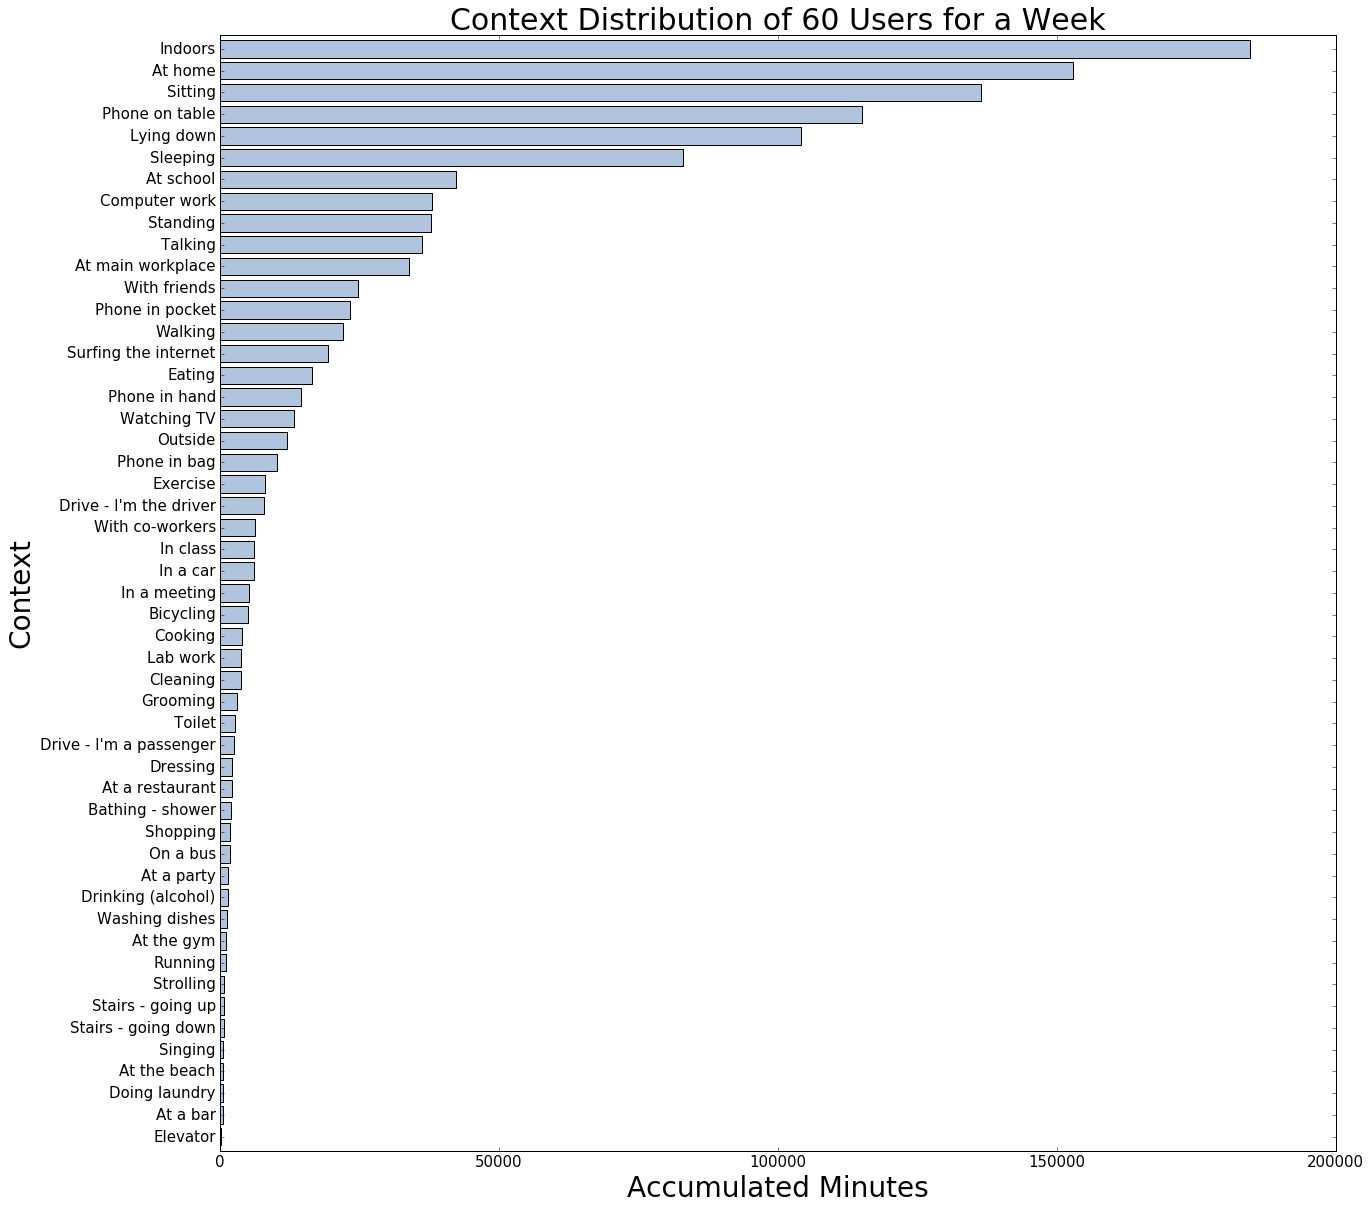

In [56]:
lb_dict = {"label":[get_label_pretty_name(lb[6:]) for lb in labelsum_dict.keys()],"count":list(labelsum_dict.values())}
label_df = pd.DataFrame(lb_dict)
label_df= label_df.sort_values(by = "count", ascending  = False)
label_df = label_df.iloc[1:] # get rid of label_source which is useless here
# label_df = label_df.iloc[:20] # choose top 20 to show
myplot = label_df.plot(figsize = (20,20), kind = "barh", color = "#B0C4DE", width = 0.8,
                               x = "label", y = "count", legend = False)
myplot.invert_yaxis()
plt.xlabel("Accumulated Minutes", fontsize = 28)
plt.ylabel("Context", fontsize = 28)
plt.title("Context Distribution of 60 Users for a Week", fontsize = 30)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [9]:
# pie chart for Body state
label_avg = df[all_label].agg(*(
        avg(c).alias(c) for c in all_label
    ))

labelmean_dict = label_avg.first().asDict()

In [30]:
def pie_chart(labels_to_display,title_str,ax,colors):
    portions_to_display = [labelmean_dict['label:'+label] for label in labels_to_display];
    pretty_labels_to_display = [get_label_pretty_name(label) for label in labels_to_display];
    ax.pie(portions_to_display,labels=pretty_labels_to_display,colors=colors);
    ax.axis('equal');
    plt.title(title_str);
    return;

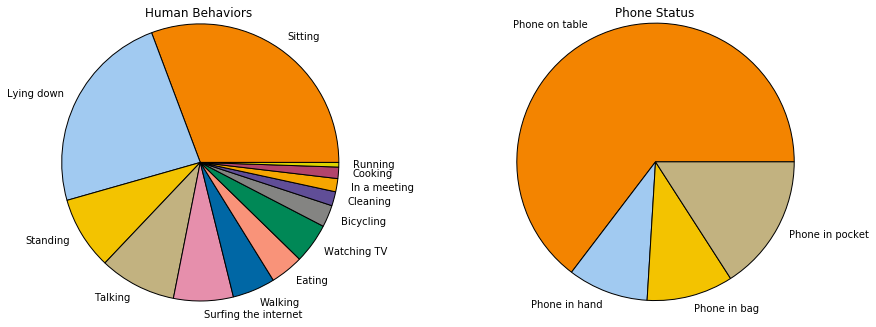

In [54]:
fig = plt.figure(figsize=(15,5),facecolor='white');

colors =  [  '#F38400', '#A1CAF1', '#F3C300',
           '#C2B280',   '#E68FAC', '#0067A5', '#F99379', '#008856','#848482',
           '#604E97', '#F6A600', '#B3446C', '#DCD300', '#882D17', '#8DB600', '#654522', '#E25822', '#2B3D26']

ax1 = plt.subplot(1,2,1);
labels_to_display = ['SITTING','LYING_DOWN','OR_standing',
                    'TALKING','SURFING_THE_INTERNET','FIX_walking','EATING','WATCHING_TV',
                     'BICYCLING','CLEANING','IN_A_MEETING','COOKING','FIX_running',]; # Human Behavior
pie_chart(labels_to_display,'Human Behaviors',ax1,colors);

ax2 = plt.subplot(1,2,2);
labels_to_display = ['PHONE_ON_TABLE','PHONE_IN_HAND','PHONE_IN_BAG','PHONE_IN_POCKET',];# Phone Status
pie_chart(labels_to_display,'Phone Status',ax2,colors);

The pie chart of "Human Behaviors" indicates users lay down, sit and stand in most time. It looks sensible.
The right one about phone status shows people tend to put their phone on table or in pocket.

<a id='preprocessing'></a>
## Data Preprocessing

In [16]:
# audio, gyroscope, acceleration in cellphone and smart watch
sensors = ['audio','proc','raw','watch']  
# we chose 10 labels with the highest accumulated minutes to train a model
labelnames = ['label:OR_indoors',
 'label:LOC_home',
 'label:SITTING',
 'label:PHONE_ON_TABLE',
 'label:LYING_DOWN',
 'label:SLEEPING',
 'label:AT_SCHOOL',
 'label:COMPUTER_WORK',
 'label:OR_standing',
 'label:TALKING']

In [17]:
# sub_id to uuids dictionary
# uuids is used for later train_test split, which is proviede by our data source.
id_dict = {'1': '61359772-D8D8-480D-B623-7C636EAD0C81',
     '2': '40E170A7-607B-4578-AF04-F021C3B0384A',
     '3': '806289BC-AD52-4CC1-806C-0CDB14D65EB6',
     '4': '61976C24-1C50-4355-9C49-AAE44A7D09F6',
     '5': 'D7D20E2E-FC78-405D-B346-DBD3FD8FC92B',
     '6': '7D9BB102-A612-4E2A-8E22-3159752F55D8',
     '7': '5119D0F8-FCA8-4184-A4EB-19421A40DE0D',
     '8': '9DC38D04-E82E-4F29-AB52-B476535226F2',
     '9': 'A7599A50-24AE-46A6-8EA6-2576F1011D81',
     '10': '59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2',
     '11': '24E40C4C-A349-4F9F-93AB-01D00FB994AF',
     '12': '9759096F-1119-4E19-A0AD-6F16989C7E1C',
     '13': '1155FF54-63D3-4AB2-9863-8385D0BD0A13',
     '14': '96A358A0-FFF2-4239-B93E-C7425B901B47',
     '15': '78A91A4E-4A51-4065-BDA7-94755F0BB3BB',
     '16': 'F50235E0-DD67-4F2A-B00B-1F31ADA998B9',
     '17': '1538C99F-BA1E-4EFB-A949-6C7C47701B20',
     '18': '11B5EC4D-4133-4289-B475-4E737182A406',
     '19': '098A72A5-E3E5-4F54-A152-BBDA0DF7B694',
     '20': '59818CD2-24D7-4D32-B133-24C2FE3801E5',
     '21': '33A85C34-CFE4-4732-9E73-0A7AC861B27A',
     '22': '00EABED2-271D-49D8-B599-1D4A09240601',
     '23': '136562B6-95B2-483D-88DC-065F28409FD2',
     '24': 'B9724848-C7E2-45F4-9B3F-A1F38D864495',
     '25': 'CF722AA9-2533-4E51-9FEB-9EAC84EE9AAC',
     '26': 'FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF',
     '27': 'A5CDF89D-02A2-4EC1-89F8-F534FDABDD96',
     '28': '0BFC35E2-4817-4865-BFA7-764742302A2D',
     '29': 'BEF6C611-50DA-4971-A040-87FB979F3FC1',
     '30': '4FC32141-E888-4BFF-8804-12559A491D8C',
     '31': 'A76A5AF5-5A93-4CF2-A16E-62353BB70E8A',
     '32': '3600D531-0C55-44A7-AE95-A7A38519464E',
     '33': '2C32C23E-E30C-498A-8DD2-0EFB9150A02E',
     '34': '86A4F379-B305-473D-9D83-FC7D800180EF',
     '35': '99B204C0-DD5C-4BB7-83E8-A37281B8D769',
     '36': '74B86067-5D4B-43CF-82CF-341B76BEA0F4',
     '37': '5EF64122-B513-46AE-BCF1-E62AAC285D2C',
     '38': 'B7F9D634-263E-4A97-87F9-6FFB4DDCB36C',
     '39': 'A5A30F76-581E-4757-97A2-957553A2C6AA',
     '40': 'C48CE857-A0DD-4DDB-BEA5-3A25449B2153',
     '41': '83CF687B-7CEC-434B-9FE8-00C3D5799BE6',
     '42': '0A986513-7828-4D53-AA1F-E02D6DF9561B',
     '43': '7CE37510-56D0-4120-A1CF-0E23351428D2',
     '44': 'E65577C1-8D5D-4F70-AF23-B3ADB9D3DBA3',
     '45': 'CCAF77F0-FABB-4F2F-9E24-D56AD0C5A82F',
     '46': 'CA820D43-E5E2-42EF-9798-BE56F776370B',
     '47': '8023FE1A-D3B0-4E2C-A57A-9321B7FC755F',
     '48': '481F4DD2-7689-43B9-A2AA-C8772227162B',
     '49': 'CDA3BBF7-6631-45E8-85BA-EEB416B32A3C',
     '50': '4E98F91F-4654-42EF-B908-A3389443F2E7',
     '51': 'ECECC2AB-D32F-4F90-B74C-E12A1C69BBE2',
     '52': 'B09E373F-8A54-44C8-895B-0039390B859F',
     '53': 'BE3CA5A6-A561-4BBD-B7C9-5DF6805400FC',
     '54': '797D145F-3858-4A7F-A7C2-A4EB721E133C',
     '55': '1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842',
     '56': '665514DE-49DC-421F-8DCB-145D0B2609AD',
     '57': '5152A2DF-FAF3-4BA8-9CA9-E66B32671A53',
     '58': '0E6184E1-90C0-48EE-B25A-F1ECB7B9714E',
     '59': '27E04243-B138-4F40-A164-F40B60165CF3',
     '60': '81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0'}

In [18]:
# get feature func
def get_fea(sensor): # sensor
    fea = ['uuids']+[col for col in df.columns if sensor in col]+labelnames
    return fea
def get_all_fea(sensors): # sensors is list of strings(sensor)
    fea = ['uuids']
    for sensor in sensors:
        fea+=[col for col in df.columns if sensor in col]
    fea+=labelnames
    return fea

# change type func
def FloatSafe(value): # In case there are non-integer type to be converted.
    try:
        return float(value)
    except ValueError:
        return None
    
def changetype(df): # change the type in schema
    for col in df.columns: 
        if col == 'sub_id' or col == '_id' or col=='uuids':
            df = df.withColumn(col, df[col].cast(StringType()))
        else:
            df = df.withColumn(col, df[col].cast(FloatType()))
    return df

In [19]:
# map sub_id into uuids in dataframe.
sub_uuids = udf(lambda x:id_dict[x]) # self-defined func
df = df.withColumn('uuids',sub_uuids('sub_id'))
fea = get_all_fea(sensors) # use all sensors data
df = df[fea]

# change fea with num and label into float type
floatsafe = udf(lambda x: FloatSafe(x))
for col in fea[1:]:
    df = df.withColumn(col,floatsafe(col))
df = changetype(df)

<a id='imputation'></a>
## Imputation

In [20]:
def fill_with_mean(df, exclude=set()):
    '''function to impute null in numeric features with their mean'''
    stats = df.agg(*(
        avg(c).alias(c) for c in df.columns if c not in exclude
    ))
    return df.na.fill(stats.first().asDict())

In [21]:
# drop rows with any null value in labels or uuids
dropped_df = df.dropna(subset=list(['uuids']+labelnames))

In [22]:
# fill the 'NA' in feature with the mean value of the column
imputed_df = fill_with_mean(dropped_df, exclude=set(['uuids']+labelnames))

<a id='split'></a>
## Data Split

In [23]:
tr_id_path = 'train_test_set/train_uuids.txt'
te_id_path = 'train_test_set/test_uuids.txt'

In [24]:
# get train and test list
sc = SparkContext.getOrCreate()
ss = SparkSession.builder.getOrCreate()
schema = StructType([StructField("uuids", StringType(), True)])
# train_id = sc.textFile(tr_id_path, 4).map(lambda x:  x.split(","))
# train_id_df =ss.createDataFrame(train_id, schema)
# train_id_df.printSchema()
train_id = sc.textFile(tr_id_path, 4).flatMap(lambda x:x.split(","))
train_id_l = train_id.collect()
test_id = sc.textFile(te_id_path, 4).flatMap(lambda x:x.split(","))
test_id_l = test_id.collect()

In [25]:
check_tr=udf(lambda x: x in train_id_l)
check_te=udf(lambda x: x in test_id_l)
train_data= imputed_df.withColumn('selected',check_tr('uuids')).filter("selected==True").drop('selected').cache()
test_data= imputed_df.withColumn('selected',check_te('uuids')).filter("selected==True").drop('selected').cache()

<a id='model'></a>
## Modeling

In [27]:
outputs = []

for label in labelnames:
    
    label_drop = list(set(labelnames).difference(set([label])))
    
    print("----------{:^25}----------".format(get_label_pretty_name(label[6:])))
    train_data_ = train_data # duplicate to leave original version unchanged
    test_data_ = test_data

    for l in label_drop:
        train_data_ = train_data_.drop(l)
        test_data_ = test_data_.drop(l)

    train_data_ = train_data_.withColumnRenamed(label,'label').cache() # rename it label
    test_data_ = test_data_.withColumnRenamed(label,'label').cache()

    va = VectorAssembler(outputCol="features", inputCols=train_data_.columns[1:-1]) #except the last col.
    pendttrain = va.transform(train_data_.fillna(0, subset=train_data_.columns[1:])).select("features", 'label')
    pendttest = va.transform(test_data_.fillna(0, subset=test_data_.columns[1:])).select("features", 'label')
    # randomforest
    rf = RandomForestClassifier(maxDepth=10,maxMemoryInMB=2048,numTrees=50)
    
    rfmodel = rf.fit(pendttrain)
    rfpredicts = rfmodel.transform(pendttest)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(rfpredicts)
    print('The accuracy is %.4f'%accuracy)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(rfpredicts)
    print('The f1-score is %.4f'%f1)
    
    outputs.append([label, accuracy, f1])

----------         Indoors         ----------
The accuracy is 0.9178
The f1-score is 0.9018
----------         At home         ----------
The accuracy is 0.7436
The f1-score is 0.7458
----------         Sitting         ----------
The accuracy is 0.6599
The f1-score is 0.6599
----------     Phone on table      ----------
The accuracy is 0.7625
The f1-score is 0.7602
----------       Lying down        ----------
The accuracy is 0.7702
The f1-score is 0.7667
----------        Sleeping         ----------
The accuracy is 0.8231
The f1-score is 0.8222
----------        At school        ----------
The accuracy is 0.9277
The f1-score is 0.9031
----------      Computer work      ----------
The accuracy is 0.7928
The f1-score is 0.7599
----------        Standing         ----------
The accuracy is 0.8868
The f1-score is 0.8347
----------         Talking         ----------
The accuracy is 0.8156
The f1-score is 0.7384


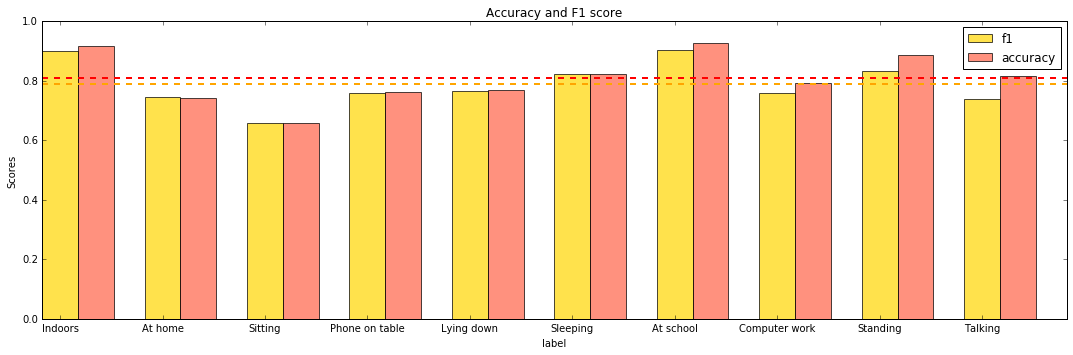

In [90]:
n_groups = 10

f1_score = [line[2] for line in outputs]
acc = [line[1] for line in outputs]
f1_mean = np.mean(f1_score)
acc_mean = np.mean(acc)

fig, ax = plt.subplots(figsize=(15,5))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.7
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, f1_score, bar_width,
                alpha=opacity, color='#FFD700', error_kw=error_config,
                label='f1')

rects2 = ax.bar(index + bar_width, acc, bar_width,
                alpha=opacity, color='#FF6347', error_kw=error_config,
                label='accuracy')

ax.axhline(f1_mean, color='#FFA500', linestyle='--',linewidth=2)
ax.axhline(acc_mean, color='#FF0000', linestyle='--',linewidth=2)

ax.set_xlabel('label')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 score')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([get_label_pretty_name(line[0][6:]) for line in outputs])
ax.legend()

fig.tight_layout()
plt.show()